# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

Blog post 
https://medium.com/@mooony5454/starbucks-capstone-challenge-17d353ab90d1

# Explore And Wrangle Data

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
% matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [6]:
portfolio.id.nunique()

10

In [8]:
# drop channels + concat portfolio with res data frame
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(portfolio['channels']),columns=mlb.classes_,index=portfolio['channels'].index)
portfolio = portfolio.drop('channels', axis=1)
portfolio = pd.concat([portfolio, res], axis=1, sort=False)

In [9]:
# number of null
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [11]:
# replace null in income with income mean
profile['income'].fillna( profile.income.mean(), inplace = True)

In [15]:
profile.id.nunique()

17000

In [16]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,17000.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,20169.288288
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,51000.000000
50%,58.000000,2.017080e+07,65404.991568
75%,73.000000,2.017123e+07,76000.000000
max,118.000000,2.018073e+07,120000.000000


In [94]:
# number of null
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [17]:
# change the data type of became_member_on 
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [18]:
# replace null in gender with NA
profile.gender.fillna('NA', inplace=True)

In [19]:
transcript.person.nunique()

17000

In [20]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [21]:
# concat transcript with transcript['value']
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [24]:
# replace the values in amount, reward and offer_id 
transcript['amount'] = 0
transcript['reward'] = 0
transcript['offer_id'] = ''

for ii,row in transcript.iterrows():
    for i in row['value']:
        if i == 'offer id' or i == 'offer_id':
            transcript.at[ii, 'offer_id']= row['value'][i]
        if i == 'amount':
            transcript.at[ii, 'amount']= row['value'][i]
        if i == 'reward':
            transcript.at[ii, 'reward']= row['value'][i]

In [25]:
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)


In [26]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [27]:
# number of null
portfolio.isnull().sum()

difficulty    0
duration      0
id            0
offer_type    0
reward        0
email         0
mobile        0
social        0
web           0
dtype: int64

In [28]:
# drop value 
transcript = transcript.drop('value', axis=1)

In [29]:
portfolio.nunique()

difficulty     5
duration       5
id            10
offer_type     3
reward         5
email          1
mobile         2
social         2
web            2
dtype: int64

# Analyse Data

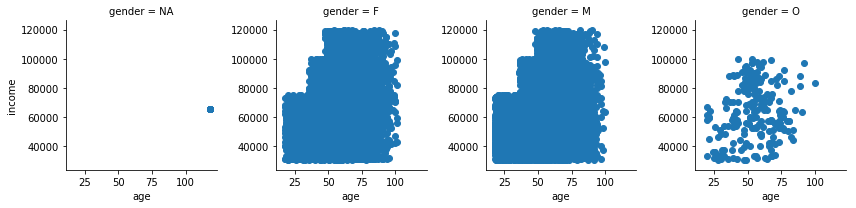

In [30]:
# scatter diagram with age, income and gender 
g = sns.FacetGrid(data = profile, col = 'gender');
g.map(plt.scatter, 'age', 'income');

it shows that gender M and F are the most 

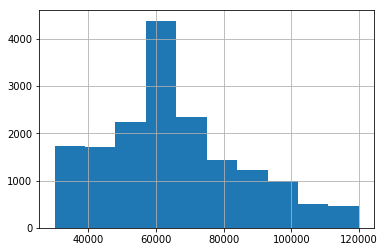

In [32]:
# income histogram 
profile.income.hist()

income 60000 is the most 

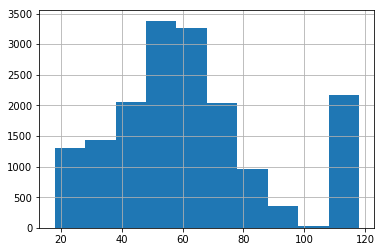

In [33]:
# age histogram
profile.age.hist()

 it shows 50 is the most 

In [71]:
# minamum age 
profile.age.min()

18

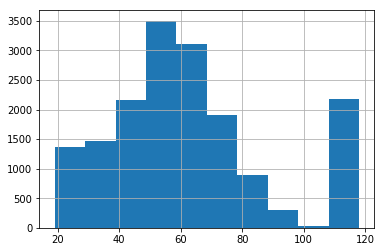

In [73]:
# age>18 histogram
profile[profile.age > 18].age.hist()

it shows 50 has the heighest number of age >18

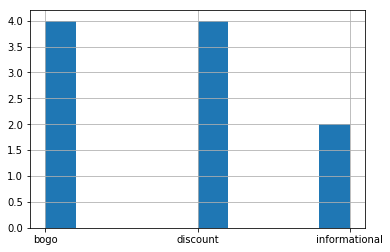

In [36]:
# offer type histogram
portfolio.offer_type.hist()

bogo and discount at the same level at 4 but informationl is at 2

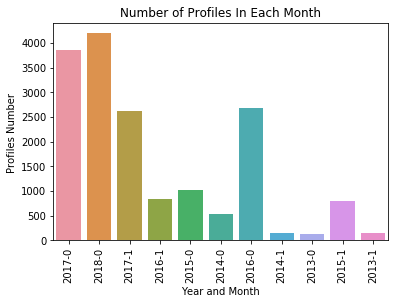

In [46]:
# new variable became_member_on_month
profile['became_member_on_month'] = profile['became_member_on'].astype(str).str[:]
# plot became_member_on_month 
plt.figure()
sns.countplot(profile['became_member_on_month'])
plt.title('Profiles Number With Months')
plt.ylabel('Profiles Number ')
plt.xlabel('Year and Month')
plt.xticks(rotation = 90)
plt.show();

2013 is the least but 2018 is the most 

In [47]:
#describtion on age mean
profile['age'].describe()['mean']

62.531411764705879

In [48]:
#describtion on income mean
profile['income'].describe()['mean']

65404.991568296799

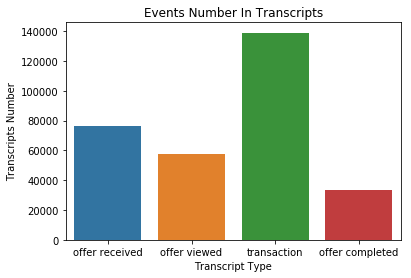

In [51]:
# plot event 
sns.countplot(transcript['event'])
plt.title('Events Number In Transcripts')
plt.ylabel('Transcripts Number')
plt.xlabel('Transcript Type')
plt.show();

lowest is offer completed and the hieghest is transaction

In [53]:
# get the customer income 
def customerIncome(profile_id):
    income = profile[profile['id'] == profile_id]['income'].values[0]
    return income

In [54]:
# get the offer type 
def offerType(offer_id):
    try:
        offer_type = portfolio[portfolio['id'] == offer_id]['offer_type'].values[0]
        return offer_type
    except:
        offer_type = 'NA'
        return offer_type

In [55]:
transcript['income'] = transcript.apply(lambda x: customerIncome(x['person']), axis=1)
transcript['offer_type'] = transcript.apply(lambda x: offerType(x['offer_id']), axis=1)

In [57]:
# save to transcript2.csv
transcript.to_csv('transcript2.csv')

In [58]:
# read from transcript2.csv
transcript2 = pd.read_csv('transcript2.csv').iloc[:, 1:]

In [59]:
# the number of null 
transcript2.isna().sum()

event              0
person             0
time               0
amount             0
reward             0
offer_id      138953
income             0
offer_type    138953
dtype: int64

In [60]:
# replace the null in offer_type and offer_id
na = ['offer_id','offer_type']
for i in na:
    transcript2[i] = transcript2[i].fillna('NA')
transcript2.isna().sum()

event         0
person        0
time          0
amount        0
reward        0
offer_id      0
income        0
offer_type    0
dtype: int64

# Model Data

In [61]:
transcript2.head()

,event,person,time,amount,reward,offer_id,income,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,100000.000000,bogo
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,65404.991568,discount
2,offer received,e2127556f4f64592b11af22de27a7932,0,0,0,2906b810c7d4411798c6938adc9daaa5,70000.000000,discount
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,65404.991568,discount
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,65404.991568,bogo


In [64]:
transcript2 = transcript2[transcript2['offer_id'] != 'NA']

In [65]:
# replace texts with numbers
eventLabels = transcript2['event'].astype('category').cat.categories.tolist()
eventReplace = {'event' : {i: ii for i,ii in zip(eventLabels,list(range(1,len(eventLabels)+1)))}}
offerTypeLabels = transcript2['offer_type'].astype('category').cat.categories.tolist()
offerTypeReplace = {'offer_type' : {i: ii for i,ii in zip(offerTypeLabels,list(range(1,len(offerTypeLabels)+1)))}}
offerIdLabels= transcript2['offer_id'].astype('category').cat.categories.tolist()
offerIdReplace= {'offer_id' : {i: ii for i,ii in zip(offerIdLabels,list(range(1,len(offerIdLabels)+1)))}}

print(eventReplace)
print(offerTypeReplace)
print(offerIdReplace)

{'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3}}
{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}
{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, '2906b810c7d4411798c6938adc9daaa5': 3, '3f207df678b143eea3cee63160fa8bed': 4, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5, '5a8bc65990b245e5a138643cd4eb9837': 6, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, 'fafdcd668e3743c1bb461111dcafc2a4': 10}}


In [66]:
# replace texts with numbers
transcript2.replace(eventReplace, inplace=True)
transcript2.replace(offerIdReplace, inplace=True)
transcript2.replace(offerTypeReplace, inplace=True)

In [67]:
transcript2.head()

,event,person,time,amount,reward,offer_id,income,offer_type
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,7,100000.000000,1
1,2,a03223e636434f42ac4c3df47e8bac43,0,0,0,1,65404.991568,2
2,2,e2127556f4f64592b11af22de27a7932,0,0,0,3,70000.000000,2
3,2,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0,10,65404.991568,2
4,2,68617ca6246f4fbc85e91a2a49552598,0,0,0,5,65404.991568,1


In [68]:
# Split transcript2 into target and features
features = transcript2.drop(['offer_type','person'], axis = 1)
target = transcript2['offer_type']

In [69]:
# normalize numerical values
scaler = MinMaxScaler()
to_normalize = ['reward', 'income','time', 'amount' ]
features[to_normalize] = scaler.fit_transform(features[to_normalize])
features.head()

,event,time,amount,reward,offer_id,income
0,2,0.0,0.0,0.0,7,0.777778
1,2,0.0,0.0,0.0,1,0.393389
2,2,0.0,0.0,0.0,3,0.444444
3,2,0.0,0.0,0.0,10,0.393389
4,2,0.0,0.0,0.0,5,0.393389


trying to see different classifiers accuracy 

In [79]:
# create train and test 
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(f'K-NN classifier accuracy on train set: {round(knn.score(X_train, y_train)*100,2)}%.')
# Naive Bayes
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
print(f'Naive Bayes classifier accuracy on train set: {round(gnb.score(X_train, y_train)*100,2)}%.')
# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
print(f'SVM classifier accuracy on train set: {round(svm.score(X_train, y_train)*100,2)}%.')

K-NN classifier Accuracy on train set: 100.0%.
Naive Bayes classifier Accuracy on train set: 48.97%.
SVM classifier Accuracy on train set: 100.0%.


it shows that K-NN classifier and SVM classifier have an accuracy of 100% but Naive Bayes classifier Accuracy is 48.97%

first in this project i explored and wrangled Data then analysed in the end i did modeling for the data 
in explore and wrangle data i cleaned the data such as dropping uncessery columns and changing the the type of data 
then in the analyzation i analysed all of profile,portfolio  and transcript and found that bogo and discount offers are the most that people want but informationl is the least
also that event in offer completed is the lowest and the hieghest is transaction
after that the modeling shows that K-NN classifier and SVM classifier have an accuracy of 100%.
So, from the previous i concluded that offers to customers should be made more on bogo and discount offers because they are the most favourite.